In [56]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
%reload_ext autoreload
%autoreload 2

# EDA

Set a predetermined seed so all our results can be replicated

In [4]:
RANDOM_SEED = 1337

### Data Source Description
- Raw data can be downloaded from: https://www.kaggle.com/datasets/abhinav89/telecom-customer?resource=download
- Data can be cleaned by running clean_raw.py in the repository to get the data into the form used in this notebook.
- Data was originally provided by Teradata Center for Customer Relationship Management, located at the Fuqua School of Business, Duke University for a tournament in 2002. 
    - The data was compiled for a three month period and then whether or not the customers churned in the fifth month was recorded (churn data has a one month lag as the industry requires a month to predict and setup any campaigns to target potential churn customers, hence only churn data in the lagged month is relevant for business decisions)
    - As the original dataset and many of the descriptions of variables within the data are no longer available, the data we are working with is only a subset of the original data. 

In [24]:
full_data = pd.read_csv('Dataset/clean_data.csv', index_col='Customer_ID')

- Data contains 100,000 rows and 97 features
- Customer_ID serves as the primary key for each customer 
- Target variable is 'churn' where
    -  1 = Customer Churned
    -  0 = Customer Stayed

In [6]:
full_data.shape

(100000, 97)

In [7]:
full_data.head(5)

,actvsubs,adjmou,adjqty,adjrev,adults,area,asl_flag,attempt_mean,avg3mou,avg3qty,...,threeway_mean,totcalls,totmou,totmrc_mean,totrev,truck,unan_dat_mean,unan_vce_mean,uniqsubs,vceovr_mean
Customer_ID,,,,,,,,,,,,,,,,,,,,,
1000001,1,4085.00,1602,1453.44,1.0,NORTHWEST/ROCKY MOUNTAIN AREA,0,52.333333,272,116,...,0.000000,1652,4228.00000,22.500,1504.62,0.0,0.0,6.333333,2,0.0
1000002,1,26367.00,14624,2833.88,1.0,CHICAGO AREA,0,263.333333,305,158,...,0.333333,14654,26400.00000,37.425,2851.68,1.0,0.0,61.333333,1,9.1
1000003,1,24303.05,7888,1934.47,2.0,GREAT LAKES AREA,0,9.000000,12,7,...,0.000000,7903,24385.05333,16.990,2155.91,0.0,0.0,2.666667,1,0.0
1000004,1,3035.00,1479,1941.81,4.0,CHICAGO AREA,0,3.666667,8,3,...,0.000000,1502,3065.00000,38.000,2000.90,0.0,0.0,0.000000,1,0.0
1000005,1,13965.00,4452,2166.48,1.0,NEW ENGLAND AREA,0,222.333333,558,191,...,0.000000,4485,14028.00000,71.980,2181.12,0.0,0.0,77.000000,1,0.0


Column descriptions are scraped and cleaned from the kaggle website via beautifulsoup, then had a couple columns rewritten by hand. It's been packaged in this repository for convenience's sake, and a human readable csv file can also be found in the repository. 

In [25]:
with open('columnDescriptions.json','r') as f:
    col_desc = json.load(f)
    
#shortened descriptions with elipses for plot titles
short_col_desc = dict(zip(
    col_desc.keys(),
    map(lambda desc: 
        desc if len(desc)<20 else f'{desc[:20]}...', col_desc.values()
    )
))

Our target variable in the data is surprisingly well balanced to begin with. We might still input some weights when building the model later just to make sure but this means we won't have to do much rebalancing when we are viewing the descriptive statistics during this EDA.

<AxesSubplot:xlabel='churn', ylabel='count'>

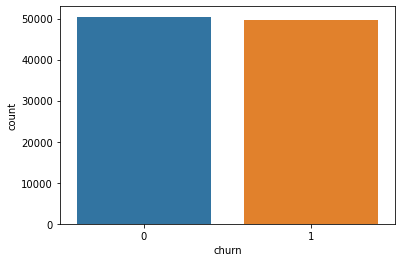

In [8]:
sns.countplot(x=full_data.churn)

Most of the missing data in our raw data have been treated either through mean or mode imputation during the preprocessing script. 

However, some of the columns within our data cannot be reliably imputed by our preprocessing, due to them being MNAR with high percentage of missingness. We therefore elected not to treat these columns so that we can better evaluate our data and prevent bias in our final model. If a model we try later cannot handle missing values, we may try more complex methods to solve missingness.

The graph below shows all columns we did not treat for missingness and their respective missingness percentages.

Text(0.5, 1.0, '% Data Missing in Each Column')

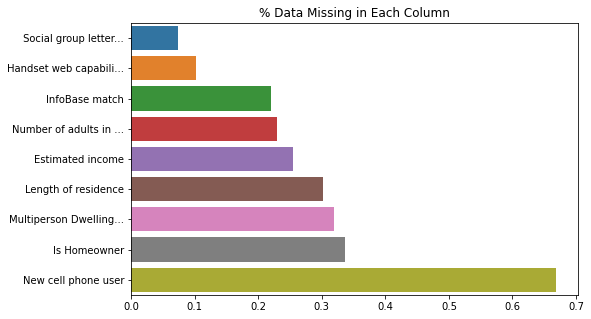

In [7]:
miss_data_cols = full_data.columns[full_data.isna().sum()>0]
pct_miss_data = (
    full_data[miss_data_cols].isna().mean()
    .sort_values()
)
plt.figure(figsize=(8,5))
ax = sns.barplot(x=pct_miss_data,y=pct_miss_data.index)
ax.set_yticklabels(pct_miss_data.index.map(short_col_desc))
ax.set_title('% Data Missing in Each Column')

# Univariate Analysis

In [26]:
cat_cols = full_data.select_dtypes(include='object').columns
num_cols = full_data.select_dtypes(include=np.number).columns
bin_cols = num_cols[full_data[num_cols].nunique()==2]
num_cols = pd.Index(set(num_cols)-set(bin_cols))
bin_cols = bin_cols[bin_cols!='churn']

### Categorical Features

In [59]:
#helper function for graphing
from graph_utils import get_subplot_dim

In [243]:
full_data[cat_cols].head(5)

,area,crclscod,dualband,hnd_webcap,marital,prizm_social_one
Customer_ID,,,,,,
1000001,NORTHWEST/ROCKY MOUNTAIN AREA,A,Y,WCMB,single,suburb
1000002,CHICAGO AREA,EA,N,WC,single,urban
1000003,GREAT LAKES AREA,C,N,NaN,married,suburb
1000004,CHICAGO AREA,B,N,NaN,married,town
1000005,NEW ENGLAND AREA,A,Y,WCMB,single,urban


Categorical Data Insights
- The data is from a U.S based company with customers across the nation
- Credit class code is likely sourced from a credit reporting agency such as Experian
- Social Group Letter is an indicator for level of urbanization of the customer's residence created by a third party PRIZM

Text(0.5, 0, 'Percentage of Data From Each Area')

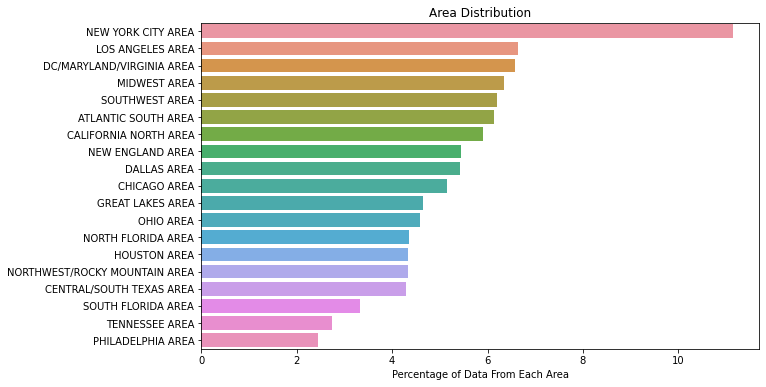

In [204]:
plt.figure(figsize=(10,6))
area_count = full_data['area'].value_counts()/full_data.shape[0]*100
ax = sns.barplot(
    x=area_count,
    y=area_count.index
)
ax.set_title('Area Distribution')
ax.set_xlabel('Percentage of Data From Each Area')

Text(0.5, 0, 'Percentage of Data From Each Class')

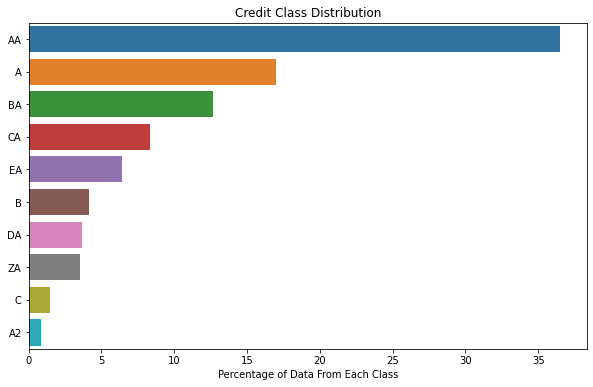

In [209]:
#Only 10 of the top most common credit classes
#out of 54 are displayed to save on clutter
plt.figure(figsize=(10,6))
credit_class_count = (
    full_data['crclscod'].value_counts().head(10)
    /full_data.shape[0]*100
)
ax = sns.barplot(
    x=credit_class_count,
    y=credit_class_count.index
)
ax.set_title('Credit Class Distribution')
ax.set_xlabel('Percentage of Data From Each Class')

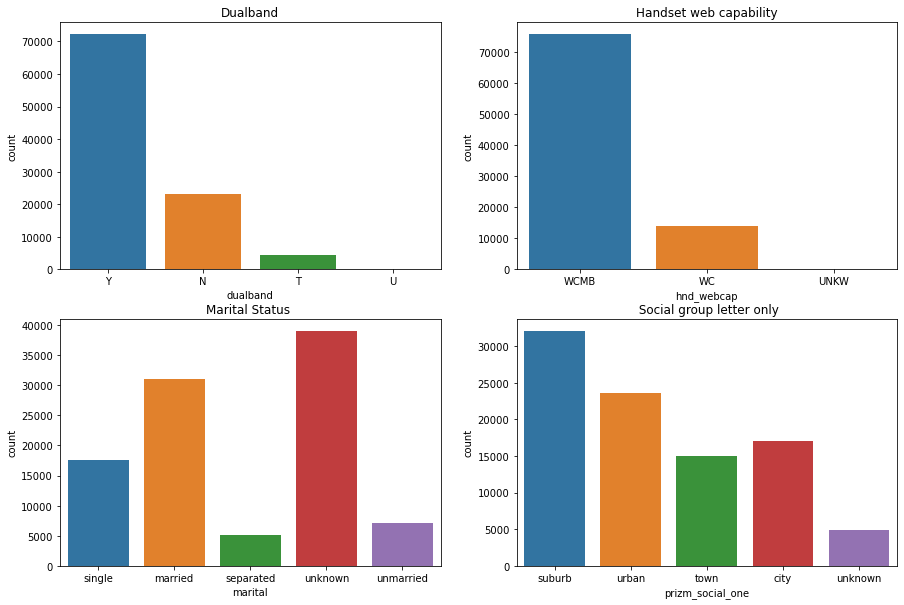

In [245]:
minor_cat_cols = cat_cols[full_data[cat_cols].nunique()<10]
r, c = get_subplot_dim(len(minor_cat_cols))
fig, ax = plt.subplots(r,c,figsize=(15,10))
for col, subplot in zip(minor_cat_cols,ax.flatten()):
    sub_ax = sns.countplot(x=full_data[col],ax=subplot)
    sub_ax.set_title(f'{col_desc[col]}')

### Numerical Data

We separate numerical columns into three groups. 
- The first group contains information before the 3 month observation period
- The second group contains monthly info during the 3 month observation period
- The third group contains other statistics gathered about the customer

In [27]:
avg_cols = num_cols[num_cols.str.contains('avg')]
mean_cols = num_cols[num_cols.str.contains('mean')]
misc_num_cols = pd.Index(set(num_cols)-set(mean_cols).union(avg_cols))

We first take a look at general average monthly statistics that contain info from before the 3 month observation period. As we can see below, all the average monthly statistics measured have significant outliers. 

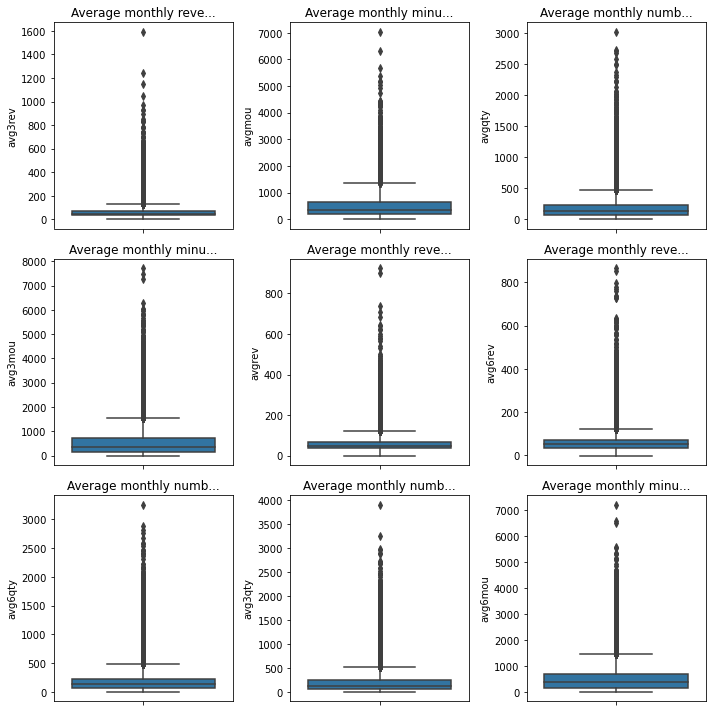

In [140]:
r,c = get_subplot_dim(avg_cols.shape[0])
fig, ax = plt.subplots(r,c,figsize=(10,10))
for col, subplot in zip(avg_cols,ax.flatten()):
    sub_ax = sns.boxplot(y=full_data[col],ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

Let us remove the outliers determined by the boxplot to better see what the rest of the data looks like.

In [55]:
def remove_outliers(data:pd.Series):
    '''Datapoints are considered to be an outlier 
    when 1.5 interquartile ranges below the first quartile
    or 1.5 interquartile ranges above the third quartile.
    '''
    low_q = data.quantile(0.25)
    up_q = data.quantile(0.75)
    iqr = up_q-low_q
    return data[
        (data>=low_q - (1.5*iqr))
        &(data<=up_q + (1.5*iqr))
    ]

As we can see, even with the outliers removed the data is still highly right skewed. 
- Many of the columns seem to measure similar things, such as number of calls, call minutes, and revenue, albeit in different time frames (3 month, 6 month, lifetime). 
- An interesting point to note is that the average monthly revenue columns distributions each have a significant dip at the $50 mark. In fact, a quick chi-square test in the cell further below of churn rates between customers with monthly revenue >$50 and those <$50 yields a p-value of ≈0.0003, meaning the two likely have different rates of churn. Hence, avg monthly revenue may be a useful indicator of churn later on in our model. 



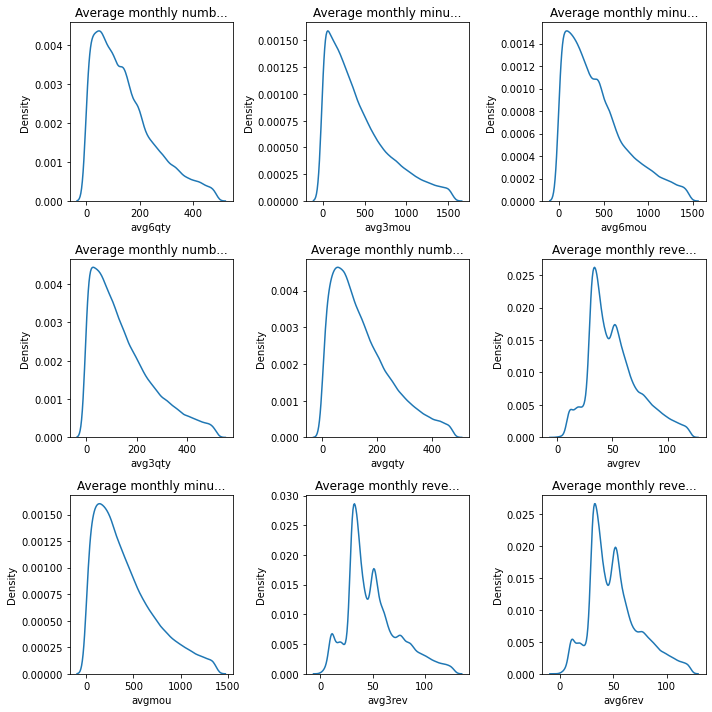

In [53]:
r,c = get_subplot_dim(avg_cols.shape[0])
fig, ax = plt.subplots(r,c,figsize=(10,10))
for col, subplot in zip(avg_cols,ax.flatten()):
    sub_ax = sns.kdeplot(x=remove_outliers(full_data[col]),ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

In [134]:
chi2, p_val, dof, expected = sp.stats.chi2_contingency(
    #create a contingency table separating whether average monthly rev
    #is above or below 50 to test churn rates via chi square"
    pd.crosstab(
        full_data['avg3rev'].apply(lambda x: 1 if x>50 else 0),
        full_data['churn']
    )
)
print(f'The p-value of the chi2 test is {p_val}')

The p-value of the chi2 test is 0.0003157843952246551


We then move on to columns with statistics from during our 3 month observation period. They likewise suffer from many outliers which need to be removed for a better look. 

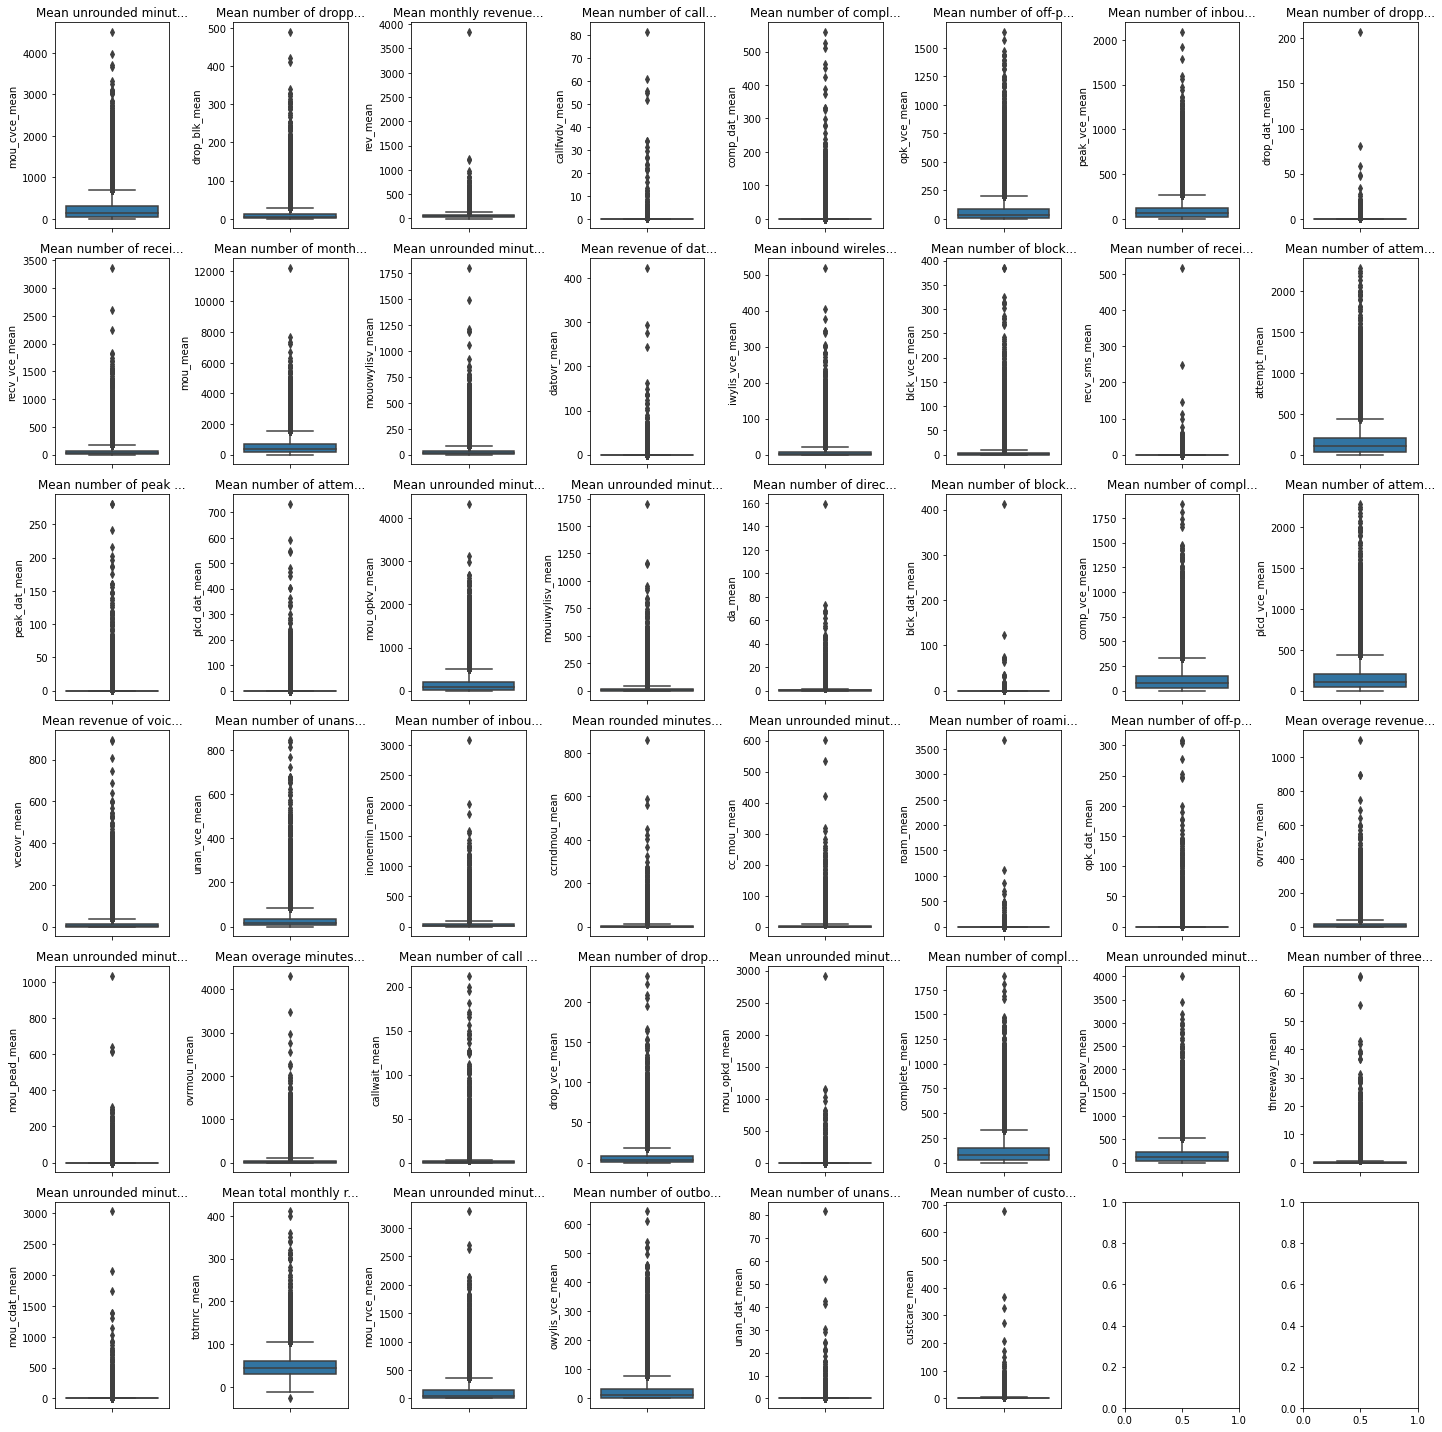

In [139]:
r,c = get_subplot_dim(mean_cols.shape[0])
fig, ax = plt.subplots(r,c,figsize=(20,20))
for col, subplot in zip(mean_cols,ax.flatten()):
    sub_ax = sns.boxplot(y=full_data[col],ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\JeffW\Anaconda3\envs\telecomChurn\lib\site-pac

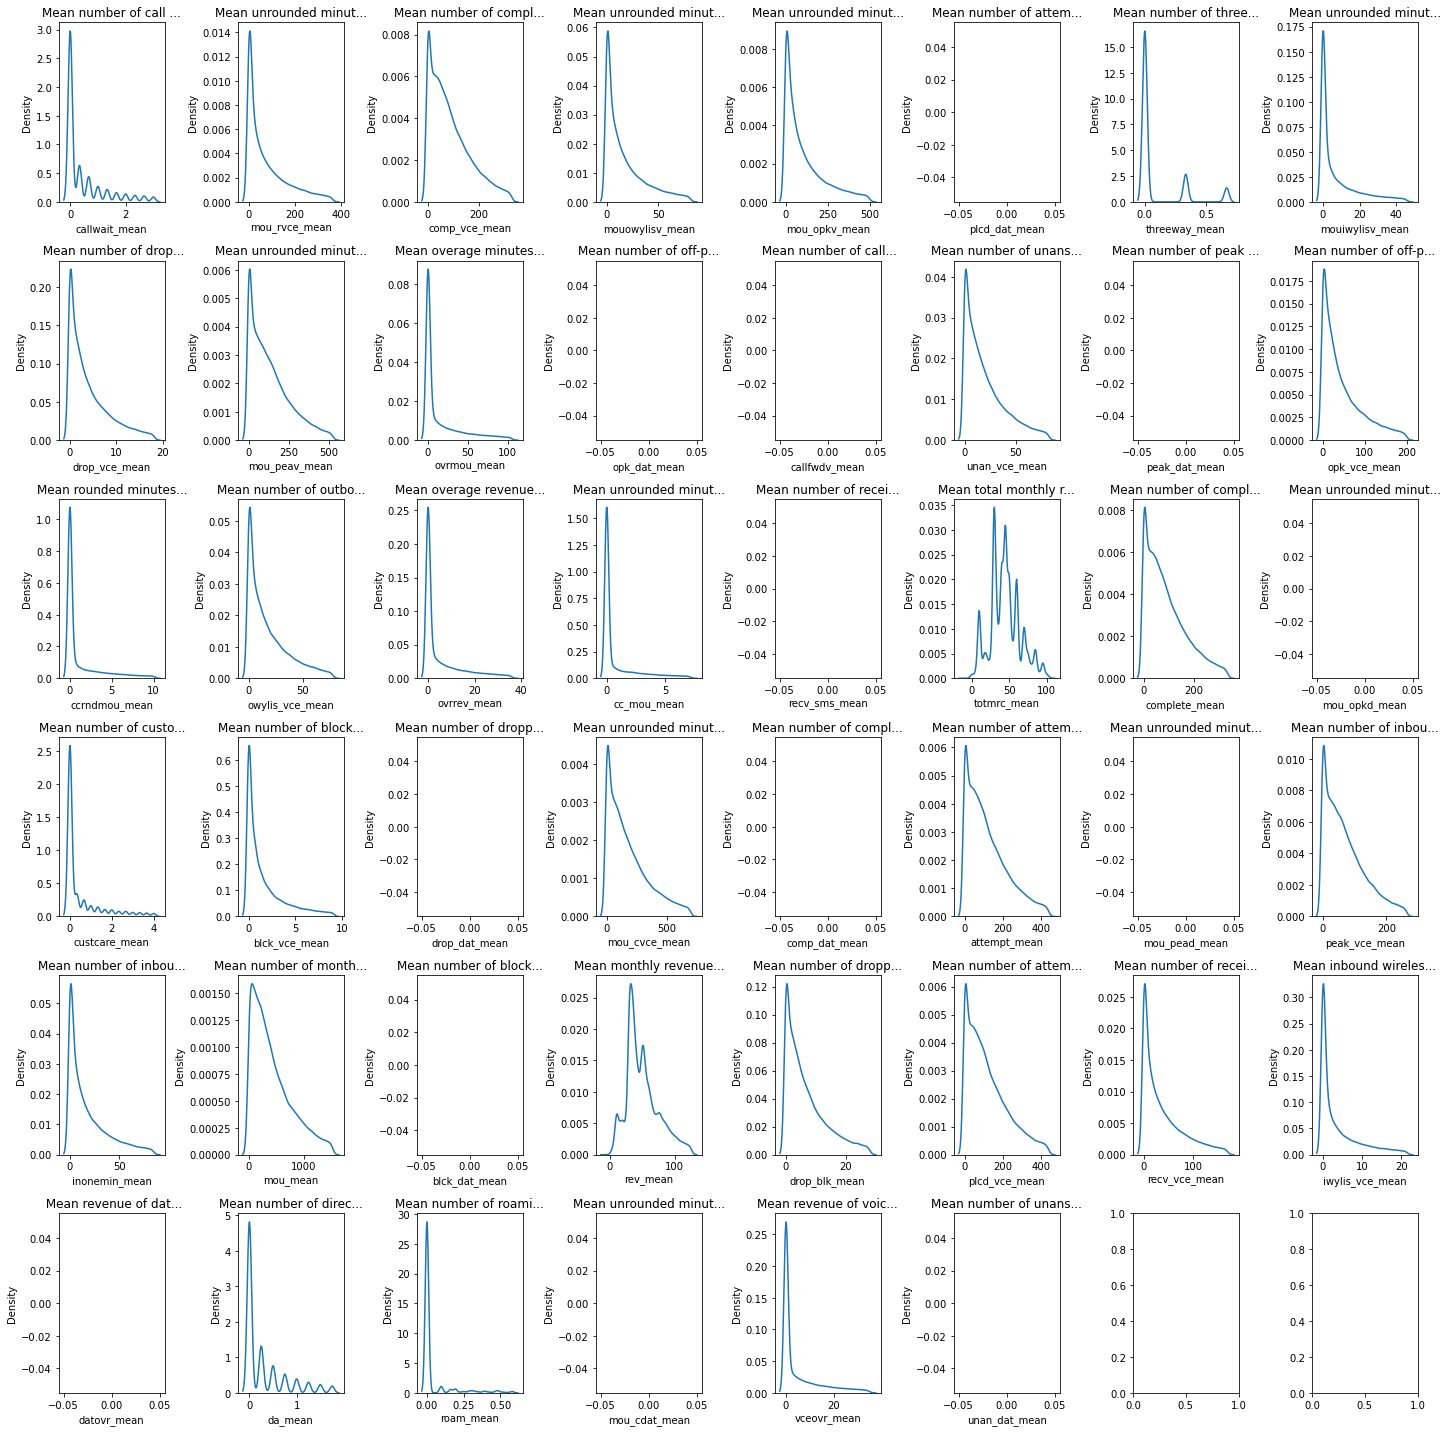

In [142]:
r,c = get_subplot_dim(mean_cols.shape[0])
fig, ax = plt.subplots(r,c,figsize=(20,20))
for col, subplot in zip(mean_cols,ax.flatten()):
    sub_ax = sns.kdeplot(x=remove_outliers(full_data[col]),ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

Miscellaneous Numerical Column Key Takeaways
- Like usage statistics, many of the columns have extreme values heavily right skewing the distribution
  - In fact, certain columns have weird values such as a household having nearly 200 lines. Though it initially looks like a data processing glitch, further examination shows that many of the household's lines are inactive, indicating the household has switched through many numbers (possible scammer abusing the service). Many columns have a small number of households with odd usage statistics such as these skewing the distribution.  
- Income is split into 9 different classes ranging from 1 to 9
- The Month's column indicates that most of the customers have been continuously using the company's services for at least a year

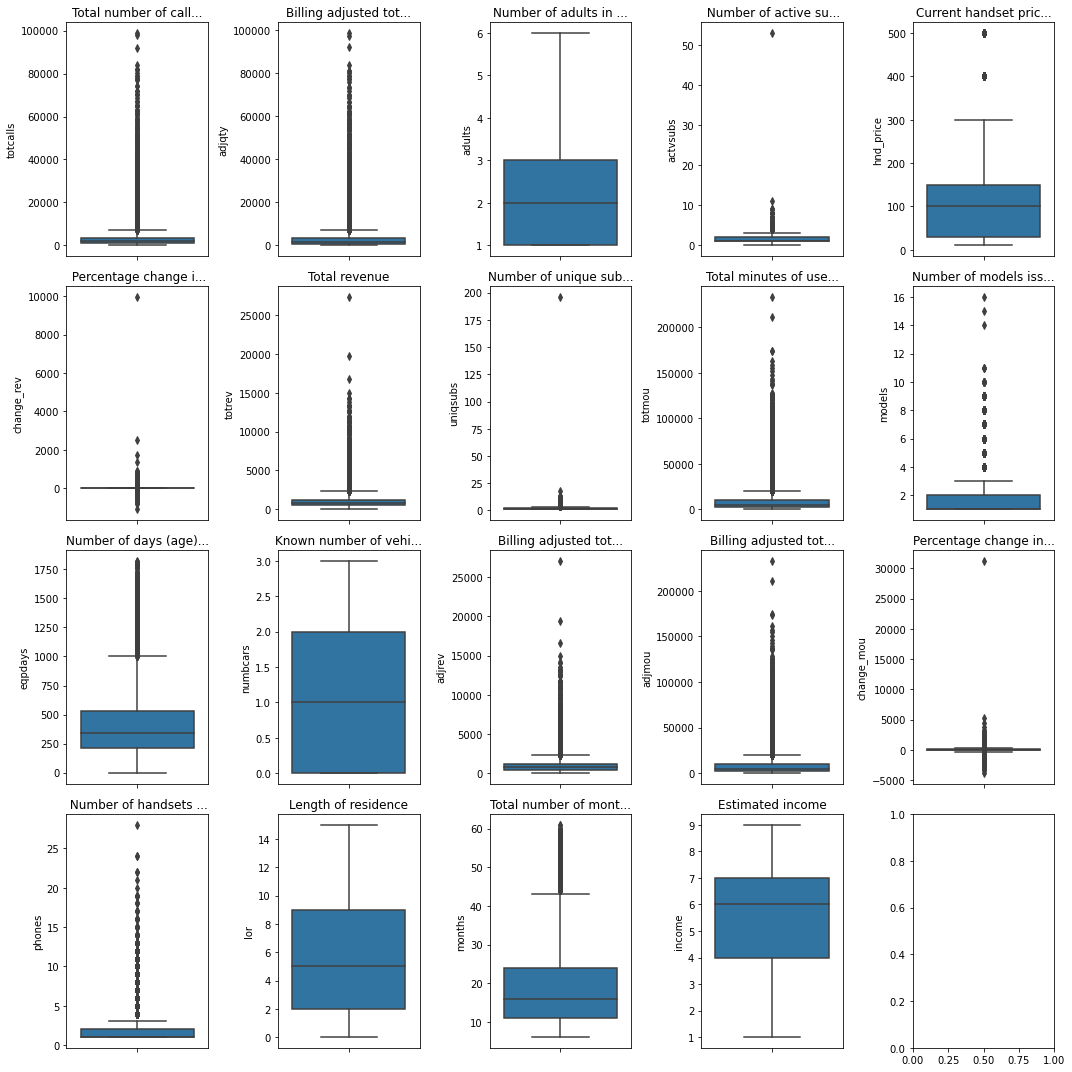

In [138]:
r,c = get_subplot_dim(misc_num_cols.shape[0])
fig, ax = plt.subplots(r,c,figsize=(15,15))
for col, subplot in zip(misc_num_cols,ax.flatten()):
    sub_ax = sns.boxplot(y=full_data[col],ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

Binary Column Key Takeaways
- There are a number of columns dedicated to whether the household has an under 18 child and what age bracket it is, with highly imbalanced classes in the original data. Hence we created another has_kid column as a single column that simplifies whether the household has an under 18 child to see if it helps simplify our model later on. 
- Columns with high missingness show before such as ownrent and infobase have highly imbalanced distribution likely since those with the negative class are more likely to not answer (non-homeowners and those without database match less likely to have responded to survey)
- In the data, RV is classified as a Truck, hence if the RV column is true for the customer then so will the Truck column

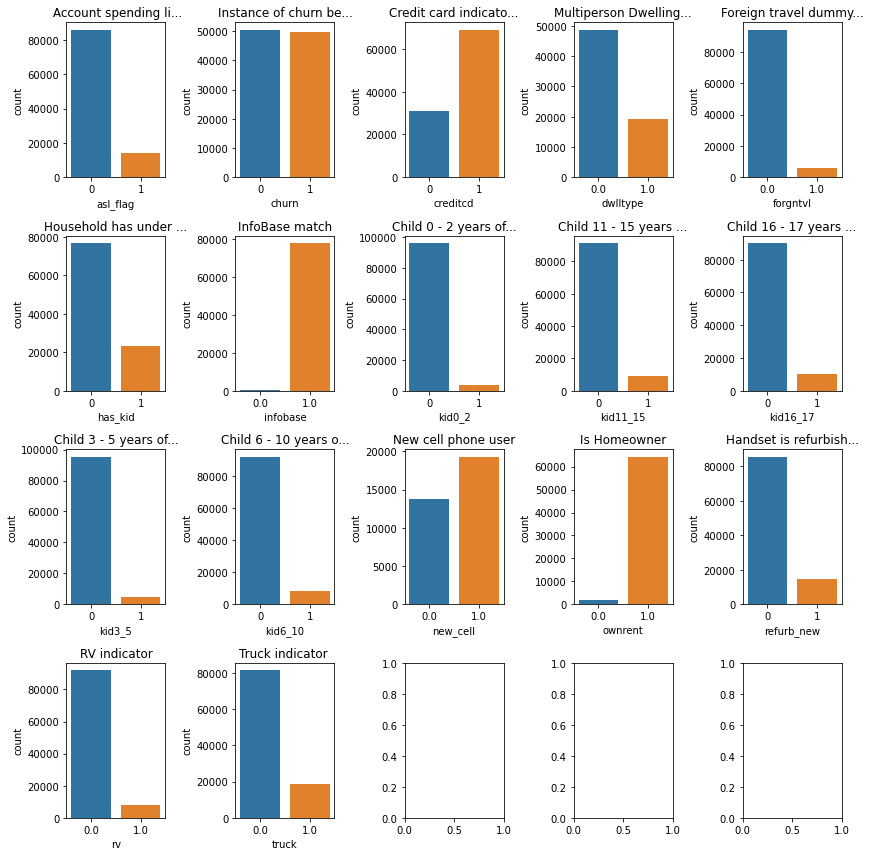

In [146]:
r,c = get_subplot_dim(bin_cols.shape[0])
fig, ax = plt.subplots(r,c,figsize=(12,12))

for col, subplot in zip(bin_cols,ax.flatten()):
    sub_ax = sns.countplot(x=full_data[col],ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

## Multivariate Analysis

In [137]:
mean_corr = full_data[list(mean_cols)+['churn']].corr()
avg_corr = full_data[list(avg_cols)+['churn']].corr()
misc_num_corr = full_data[list(misc_num_cols)+['churn']].corr()

### Correlation with Churn

Mean/Average Numerical Correlation Takeaways:
- Most numerical columns regarding usage statistics have little to no direct correlation to whether the customer churns or not (-0.06 to 0.02)
- Many of the other columns however have decently high correlations with each other, hence PCA would likely be useful down the line

<AxesSubplot:>

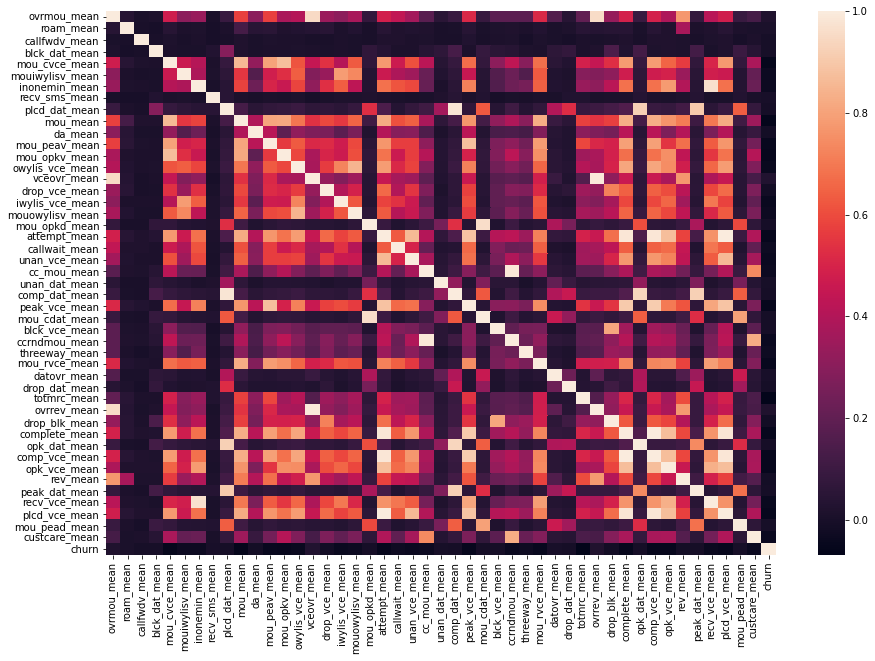

In [356]:
plt.figure(figsize=(15,10))
sns.heatmap(mean_corr)

In [11]:
#Desc stats of Pearson's correlation coefficients
#between churn and other columns
mean_corr['churn'].iloc[:-1].describe()

count    46.000000
mean     -0.024361
std       0.023055
min      -0.068682
25%      -0.045877
50%      -0.030870
75%      -0.007748
max       0.023630
Name: churn, dtype: float64

<AxesSubplot:>

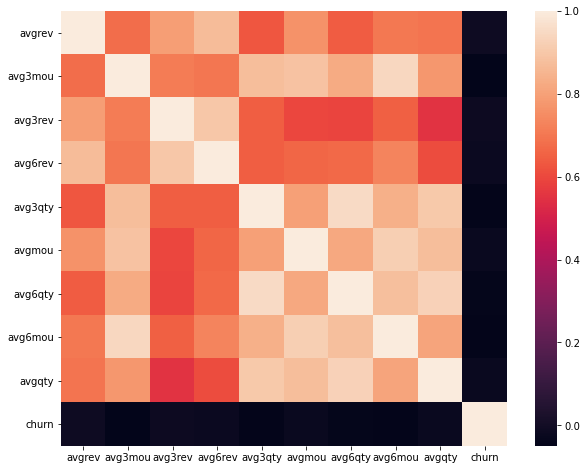

In [358]:
plt.figure(figsize=(10,8))
sns.heatmap(avg_corr)

In [376]:
#Desc stats of Pearson's correlation coefficients
#between churn and other columns
avg_corr['churn'].iloc[:-1].describe()

count    9.000000
mean    -0.029042
std      0.014926
min     -0.049546
25%     -0.043350
50%     -0.024022
75%     -0.017613
max     -0.008780
Name: churn, dtype: float64

Misc Numerical Correlation Takeaways:
- Miscellaneous numerical customer information have slightly higher direct correlation compared to the aforementioned numerical columns (-0.1 to 0.11)
- These miscellaneous columns have relatively lower correlation with each other compared to the other numerical columns
- Miscellaneous columns that still deal with usage statistics from customers such as adjusted number of calls, adjusted revenue, and total revenue (adjqty, adjrev, totrev) still have high correlations with each other

<AxesSubplot:>

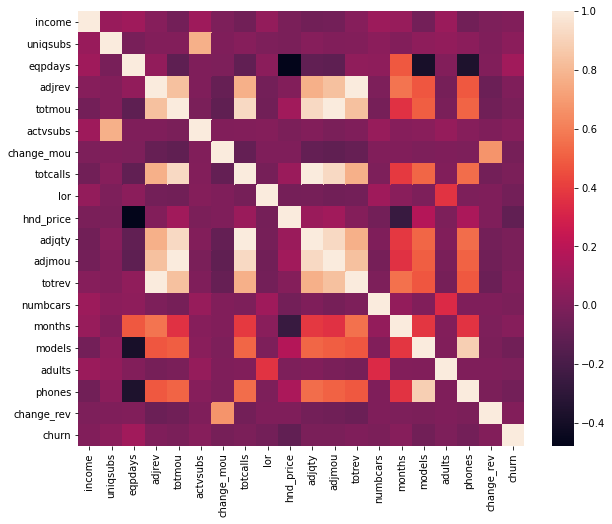

In [361]:
plt.figure(figsize=(10,8))
sns.heatmap(misc_num_corr)

In [378]:
#Desc stats of Pearson's correlation coefficients
#between churn and other columns
misc_num_corr['churn'].iloc[:-1].describe()

count    19.000000
mean     -0.007860
std       0.042658
min      -0.104197
25%      -0.024374
50%      -0.010682
75%       0.006561
max       0.112694
Name: churn, dtype: float64

In [13]:
sorted_misc_corr = misc_num_corr['churn'].abs().sort_values(ascending=False)
sorted_misc_corr.index = sorted_misc_corr.index.map(col_desc)

With the below bar plot, we can more clearly see that the handset price and age bundled with the customer phone plan are the best direct predictors of whether the customer churns.

<AxesSubplot:xlabel='churn'>

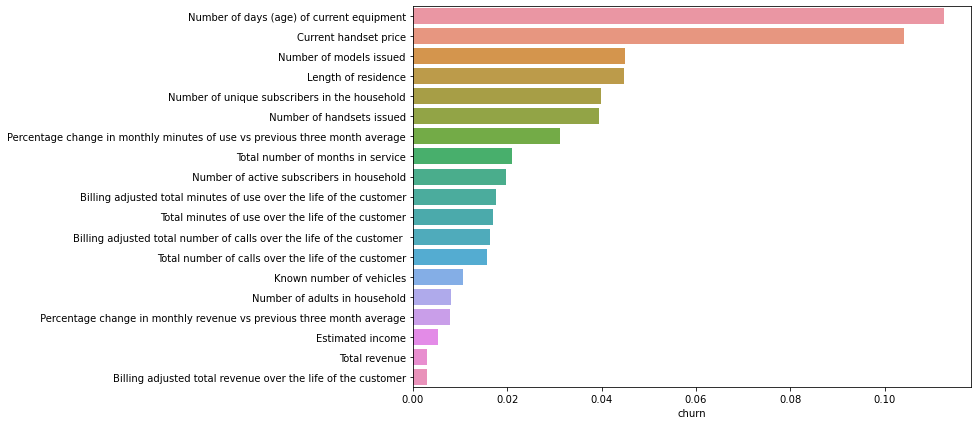

In [406]:
plt.figure(figsize=(10,7))
sns.barplot(x=sorted_misc_corr[1:],y=sorted_misc_corr.index[1:])

### Countplots

We can pull a couple of specific key columns to get an idea of their relationshp to churn rates. Below are the column names we pulled and their respective descriptions. 

In [11]:
key_num_cols = ['income','rev_mean','roam_mean','months','eqpdays']
key_str_cols = ['crclscod','prizm_social_one','area']
key_bin_cols = ['creditcd','new_cell']
pd.Series(
    pd.Index(key_num_cols+key_str_cols+key_bin_cols).map(col_desc),
    index=key_num_cols+key_str_cols+key_bin_cols
)

income                                       Estimated income
rev_mean                 Mean monthly revenue (charge amount)
roam_mean                        Mean number of roaming calls
months                      Total number of months in service
eqpdays             Number of days (age) of current equipment
crclscod                                    Credit class code
prizm_social_one                     Social group letter only
area                                         Geogrpahic area 
creditcd                                Credit card indicator
new_cell                                  New cell phone user
dtype: object

Bivariate Churn Comparison Takeaways
- There seems to be no difference in churn rates for different income levels
- Even if we only look at the interquartile range of average revenue, we can see that the distribution of average revenue for those that do not churn is slightly more left skewed than those who churn (i.e on average pay slightly less than those who churn)
- When mean monthly revenue or number of roaming calls reaches over 1500, the customer is almost certainly going to churn
- There also seems to be a lot of people ho churn when the bundled handset reaches around a year of age, hence a likely cause of churn is when the customer's bundled phone reaches a year old they will be looking for new deals to switch out for newer handsets
- 12 months seem to be a turning point in the customer lifecycle where customers decide to churn

<Figure size 432x288 with 0 Axes>

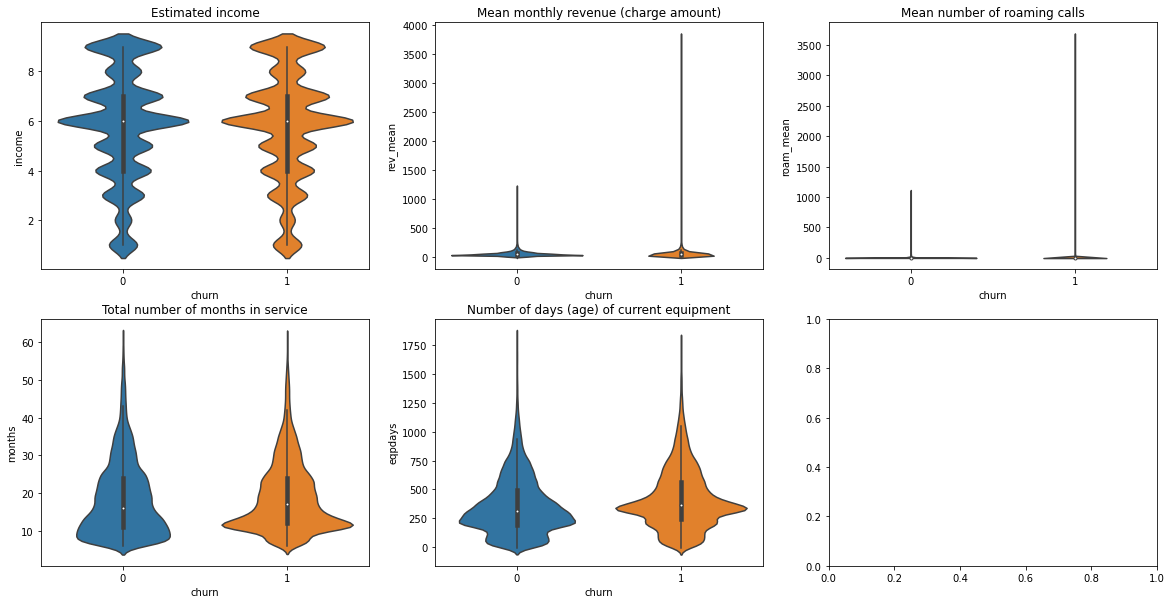

In [48]:
r, c = get_subplot_dim(len(key_num_cols))
plt.tight_layout()
fig, ax = plt.subplots(r,c,figsize=(20,10))
for col, subplot in zip(key_num_cols,ax.flatten()):
    sub_ax = sns.violinplot(data=full_data[[col,'churn']],y=col,x='churn',ax=subplot)
    sub_ax.set_title(f'{col_desc[col]}')

Text(0.5, 1.0, 'Churn Distribution of Top 10 Most Common Credit Classes')

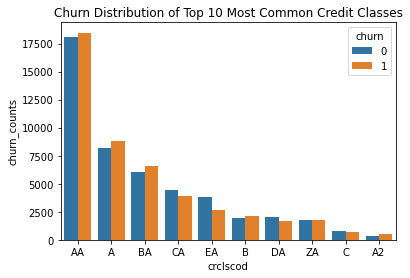

In [54]:
crd_clss_churn = full_data.groupby('crclscod')['churn'].value_counts()[
    full_data['crclscod'].value_counts().head(10).index
].rename('churn_counts').to_frame().reset_index()
ax = sns.barplot(data=crd_clss_churn,x='crclscod',y='churn_counts',hue='churn')
ax.set_title('Churn Distribution of Top 10 Most Common Credit Classes')

<AxesSubplot:xlabel='prizm_social_one', ylabel='count'>

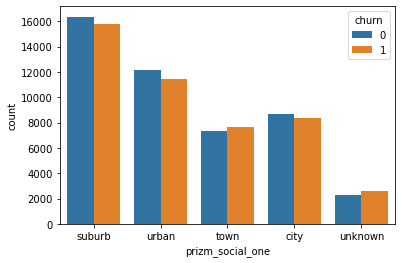

In [50]:
sns.countplot(x=full_data['prizm_social_one'],hue=full_data['churn'])

<AxesSubplot:xlabel='count', ylabel='area'>

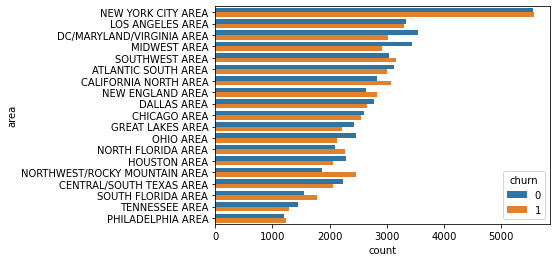

In [53]:
sns.countplot(
    y=full_data['area'],
    hue=full_data['churn'],
    order=full_data['area'].value_counts().index
)

# PCA

Since we have so many numerical columns referencing many similar features that have high correlation, we can apply PCA and take a look at the loadings to see how our data can be decomposed

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [63]:
pipe = make_pipeline(
    StandardScaler(),
    PCA(random_state=RANDOM_SEED)
)

In [154]:
decomp_data = pipe.fit_transform(full_data[num_cols].fillna(0))

In [155]:
pca = pipe.steps[1][1]

We'll only select the minimum amount of components necessary to explained 95% of the variance in our dataset so that we save time and don't have to pour over the smaller components that don't really matter

In [156]:
#get minimum n components necessary to get 95% explained variance
min_n_comps = np.argmax(pca.explained_variance_ratio_.cumsum()>0.95)

The graph below shows the explained variance ratio of each component. A component with a high ratio indicates that the component explains a lot of the variance in our data, and would be a valuable component to keep if we wished to reduce our dimensionality. 

For the purposes of EDA however, we'll simply look at the loadings of components with a high explained variance ratio to see how our many features overlap with each other and show "similar" information. We see however each successive component explains less and less of the variance, hence less and less 

<AxesSubplot:>

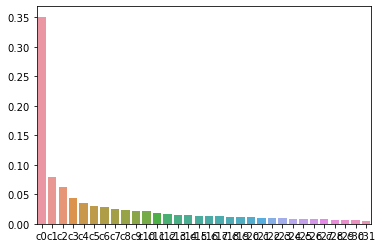

In [157]:
#Explained variance ratio
sns.barplot(
    y=pca.explained_variance_ratio_[:min_n_comps],
    x=[f'c{i}' for i in range(min_n_comps)],
)

In [158]:
def show_pca_loadings(pca:PCA,component:int):
    load_matrix = (pca.components_.T * np.sqrt(pca.explained_variance_))
    plt.figure(figsize=(8,10))
    comp_loadings = pd.Series(
        load_matrix[:,component],index=num_cols
    ).sort_values()
    comp_loadings
    ax = sns.barplot(x=comp_loadings,y=comp_loadings.index)
    ax.set_yticklabels(comp_loadings.index.map(short_col_desc))

The first component with the highest explained variance has high loadings on many of the numerical columns. This means that many of our features are showing "similar" information repeatedly. For example, we see the highest loadings in average monthly calls, minutes, charges, etc. In essence, all these features are indicating the amount of monthly usage, and hence have high correlation. This first component therefore combines the overlapping info all these features are showing into one column to be displayed here. Since we haven't began building our model and this is just for EDA purposes, this simply shows that many of our numerical features are showing similar information. 

Since this is our component with the highest explained variance ratio, if only a couple of these usage features have high loadings it would mean the primary amount of variance (i.e interesting information our data is showing) is from a small subset of features indicating a unique aspect of how our customers use our services. In our case however, most of the loadings are spread out amongst many features related to mean number of calls/minutes of use. We can therefore deduce that this first compnent with the highest explained variance is measuring something akin to the amount of usage. This is further corroborated by the fact that the Number of Days (age of equipment) column in this primary component has a strong negative loading, which makes sense since the older the bundled handset the less likely the customer is to use the service (either through low usage to begin with causing lack of handset renewel or old handset causing less inclination for usage). Since this is the component with the highest explained ratio, it means most of the variance in our data is made of customers with different amounts of usage, which can be shown through many of our usage statistics features. 

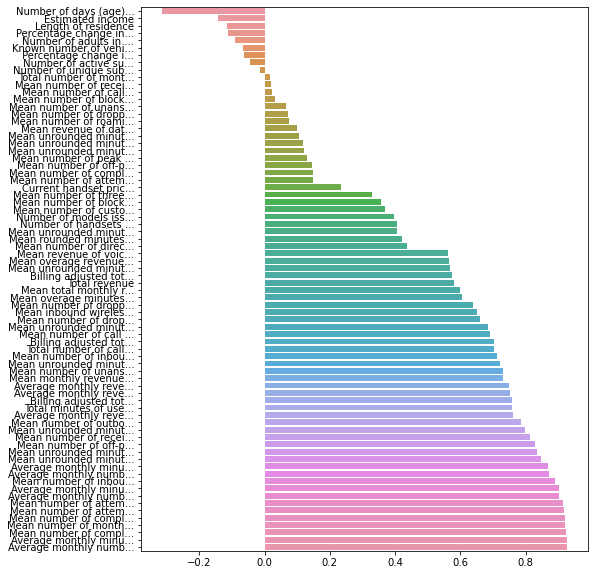

In [159]:
show_pca_loadings(pca,0)

We can pick out component 5 to serve as a contrast to better understand what the above loading means. This component is primarily made of negative loadings in miscellaneous features such as number of adults in household, estimated income, length of residence, and number of vehicles in household. If this component had a high explained variance ratio, this combination of loadings means our customers vary a lot in these features, and hence these specific columns would be an interesting dimension to analyze and separate our customers. 

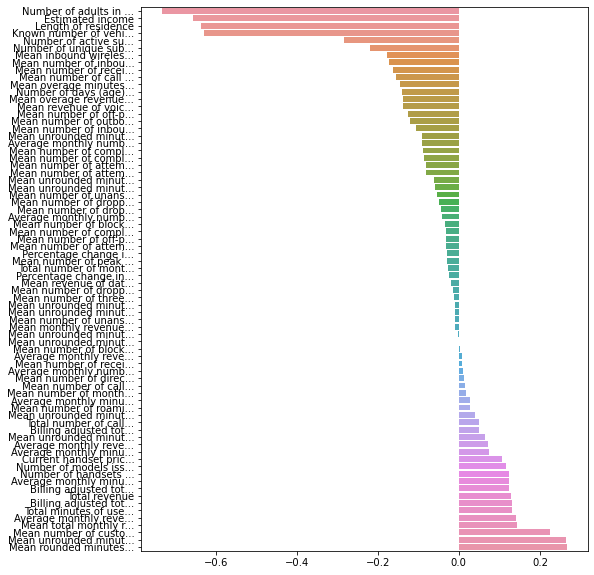

In [174]:
show_pca_loadings(pca,4)

In [160]:
pcaCorr = pd.DataFrame(
    np.hstack([
        decomp_data,
        full_data['churn'].to_numpy().reshape(-1,1)
    ]),
    columns= [f'comp_{i}' for i in range(len(num_cols))]+['churn']
).corr()

In [162]:
pcaCorr['churn'].replace(1,0).sort_values()

comp_7    -0.046292
comp_35   -0.045880
comp_0    -0.044386
comp_25   -0.043996
comp_41   -0.043158
             ...   
comp_22    0.037229
comp_38    0.042298
comp_10    0.044430
comp_3     0.048939
comp_8     0.084531
Name: churn, Length: 75, dtype: float64

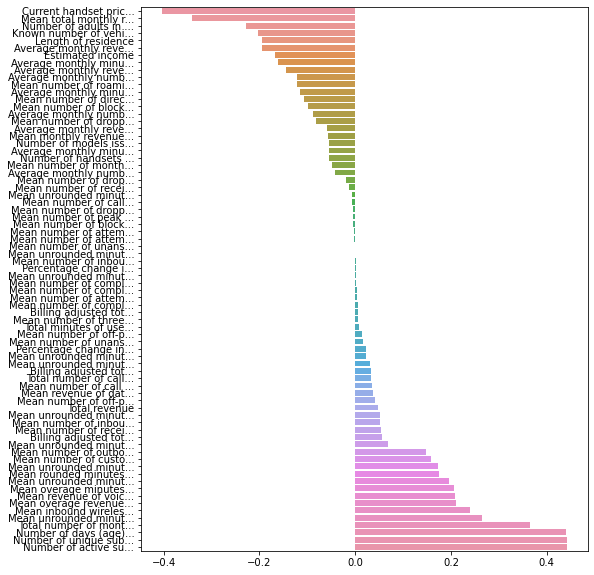

In [152]:
show_pca_loadings(pca,8)